In [ ]:
VER='v2_11_1'

[Monitor] stop monitoring


In [ ]:
!pip install catboost

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 3.8 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
!pip install lightgbm

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
!pip install dill

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
DATA_DIR='/Volumes/ws_fduacmp_001/adbuser0375/datasets'
MODEL_DIR='/Volumes/ws_fduacmp_001/adbuser0375/models'

In [ ]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.metrics import recall_score,precision_score,roc_auc_score,f1_score
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, ClassifierMixin
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold,train_test_split,RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression,ElasticNet
from sklearn.svm import LinearSVC,SVC,LinearSVR,SVR,NuSVC
import datetime
from sklearn.linear_model import HuberRegressor,OrthogonalMatchingPursuit,LinearRegression,Lars,BayesianRidge,Ridge
from lightgbm import LGBMRegressor,LGBMClassifier
from catboost import CatBoostClassifier,CatBoostRegressor
from sklearn.ensemble import StackingRegressor,VotingRegressor,RandomForestClassifier,StackingClassifier,VotingClassifier
from sklearn.ensemble import AdaBoostClassifier,AdaBoostRegressor,GradientBoostingClassifier,RandomForestRegressor,ExtraTreesClassifier,ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyRegressor,DummyClassifier
import copy
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import TransformedTargetRegressor
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import NMF,PCA
import dill

sns.set()
warnings.simplefilter('ignore', pd.errors.PerformanceWarning)


In [ ]:
SEED=42

def seed_everything(seed: int):
  """
  再現性確保を目的とした乱数固定化

  Parameters
  ----------
  seed : int
      乱数SEED
  """
  random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  np.random.seed(seed)

seed_everything(SEED)

In [ ]:
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'),index_col=0)
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'),index_col=0)
sample_submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'),index_col=0,header=None)

In [ ]:
DATE_COLUMNS=[
    'DisbursementDate',
    'ApprovalDate',
]

CAT_COLUMNS=[
  'Term',
  'NoEmp',
  'NewExist',
  'CreateJob',
  'RetainedJob',
  'FranchiseCode',
  'RevLineCr',
  'LowDoc',
  'Sector',
  'ApprovalFY',
  'City',
  'State',
  'BankState',
  'UrbanRural',
]

TARGET_COLUMN='MIS_Status'

MONEY_COLUMNS=['DisbursementGross','GrAppv','SBA_Appv']

VC_BORDER=0.02

def setup_date(df):
  for column in DATE_COLUMNS:
    date_val = pd.to_datetime(df[column])
    df['{0}_year'.format(column)] = date_val.dt.year
    df['{0}_month'.format(column)] = date_val.dt.month
    df['{0}_dow'.format(column)] = date_val.dt.day_of_week
  return df

def setup_days_between(df):
  days = pd.to_datetime(df['ApprovalDate']) - pd.to_datetime(df['DisbursementDate'])
  days = (days.dt.days // 30 * 30).clip(lower=-10000,upper=24000)
  df['days'] = days.values
  return df

def setup_money(df):
  for column in MONEY_COLUMNS:
    df[column] = df[column].apply(lambda x:float(x.replace('$','').replace(',','')))
  return df

def prepare(df):
  df = df.copy()
  df = setup_money(df)
  df = setup_date(df)
  df = setup_days_between(df)
  df['NA_Date'] = (df['DisbursementDate'].isna()|df['ApprovalDate'].isna()).astype(int)
  df['NewExist'] = df['NewExist'].astype(int)

  return df

train_prepared = prepare(train)
test_prepared = prepare(test)


In [ ]:
class DaysProbaTransformer(BaseEstimator, TransformerMixin):
  """
  daysの値(目的変数確率値)変換
  """
  def __init__(self):
    self.na_proba = 0.0
    self.proba_dict={}
    return
  def fit(self, X, y=None):
    self.na_proba = X[X['NA_Date']==1][TARGET_COLUMN].mean()
    grouped = train_prepared.groupby('days')
    for key, group in grouped:
      self.proba_dict[key] = group[TARGET_COLUMN].mean()
    return self
  def transform(self, X):
    X['days'] = X['days'].apply(lambda x:self.proba_dict[x] if x in self.proba_dict else self.na_proba)
    return X

In [ ]:
def select_decom_columns(df, columns):
  X = pd.DataFrame()
  for column in df.columns:
    if column.find('_') > -1:
      column_base = column[:column.index('_')]
    else:
      column_base = column
    if column_base in columns:
      X[column] = df[column].values
  return X

NMF_COLUMNS=[
  'City',
  'State',
  'BankState',
  'Sector',
  'UrbanRural',
  'Term',
  #'NoEmp',
  #'CreateJob',
  #'RetainedJob',
  'FranchiseCode',
]

class NMFTransformer(BaseEstimator, TransformerMixin):
  """
  NMF変換
  """
  def __init__(self,id,columns = NMF_COLUMNS,n_components=10):
    self.columns = columns
    self.selected_columns = []
    self.id = id
    self.n_components = n_components
    self.trans = NMF(n_components=n_components, random_state=SEED, max_iter=1000)
    return
  def fit(self, X, y=None):
    selected = select_decom_columns(X, self.columns)
    self.selected_columns = selected.columns
    self.trans.fit(selected)
    return self
  def transform(self, X):
    X = X.copy()
    selected = select_decom_columns(X, self.columns)
    X_new = pd.DataFrame(self.trans.transform(selected))
    rename_columns={}
    for column in X_new.columns:
      rename_columns[column]='NMF_{}_{}'.format(self.id,column)
    X_new = X_new.rename(columns=rename_columns)
    #print(rename_columns)
    for column in X.columns:
      if not column in self.selected_columns:
        X_new[column] = X[column].values
    return X_new

class PCATransformer(BaseEstimator, TransformerMixin):
  """
  NMF変換
  """
  def __init__(self,id,columns = NMF_COLUMNS,n_components=10):
    self.columns = columns
    self.selected_columns = []
    self.id = id
    self.n_components = n_components
    self.trans = PCA(n_components=n_components, random_state=SEED, )
    return
  def fit(self, X, y=None):
    selected = select_decom_columns(X, self.columns)
    self.selected_columns = selected.columns
    self.trans.fit(selected)
    return self
  def transform(self, X):
    X = X.copy()
    selected = select_decom_columns(X, self.columns)
    X_new = pd.DataFrame(self.trans.transform(selected))
    rename_columns={}
    for column in X_new.columns:
      rename_columns[column]='NMF_{}_{}'.format(self.id,column)
    X_new = X_new.rename(columns=rename_columns)
    #print(rename_columns)
    for column in X.columns:
      if not column in self.selected_columns:
        X_new[column] = X[column].values
    return X_new


class NMFProbaTransformer(BaseEstimator, TransformerMixin):
  """
  NMF項目の値(目的変数確率値)変換
  """
  def __init__(self,slice=50):
    self.proba_dict={}
    self.clip={}
    self.slice=slice
    self.columns=[]
    return
  def fit(self, X, y=None):
    X = X.copy()

    self.columns=X.columns
    for column in X.columns:
      if column[:3] != 'NMF':
        continue
      values=X[column]
      lower = values.quantile(0.01)
      upper = values.quantile(0.99)
      unit = (upper - lower) / self.slice
      self.clip[column] = {'lower':lower,'upper':upper,'unit':unit}
      X[column] = X[column] // unit * unit
      X[TARGET_COLUMN] = list(y)
      grouped = X.groupby(column)
      proba_dict = dict()
      for key, group in grouped:
        proba_dict[key] = group[TARGET_COLUMN].mean()
      self.proba_dict[column] = proba_dict
    return self
  def transform(self, X):
    X = pd.DataFrame(X, columns=self.columns)

    for column in X.columns:
      if column[:3] != 'NMF':
        continue
      values=X[column].clip(lower=self.clip[column]['lower'],upper=self.clip[column]['upper'])
      unit = self.clip[column]['unit']
      values = values // unit * unit
      X[column] = values.apply(lambda x:self.proba_dict[column][x] if x in self.proba_dict[column] else 1.0)
    return X


In [ ]:
def modular(x, column, alpha):
  val = ((x - alpha) / (x + alpha)) // 0.01 * 0.01
  return np.clip(val, -1.0, 0.75)


class MoneyProbaTransformer(BaseEstimator, TransformerMixin):
  """
  金額の値(目的変数確率値)変換
  """
  def __init__(self):
    self.proba_dict={}
    self.alpha_dict={}
    return
  def fit(self, X, y=None):
    X = X.copy()
    for column in MONEY_COLUMNS:
      alpha = X[column].median()
      self.alpha_dict[column] = alpha
      money_dict = {}
      X[column] = X[column].apply(lambda x:modular(x, column, alpha))
      grouped = X.groupby(column)
      for key, group in grouped:
        money_dict[key] = group[TARGET_COLUMN].mean()
      self.proba_dict[column] = money_dict
    return self
  def transform(self, X):
    for column in MONEY_COLUMNS:
      X[column] = X[column].apply(lambda x:modular(x, column, self.alpha_dict[column]))
      X[column] = X[column].apply(lambda x:self.proba_dict[column][x] if x in self.proba_dict[column] else 1.0)
    return X

class ModularTransformer(BaseEstimator, TransformerMixin):
  """
  指定した説明変数のmodular変換
  """
  def __init__(self, columns):
    self.alpha_dict={}
    self.columns = columns
    return
  def fit(self, X, y=None):
    X = X.copy()
    for column in self.columns:
      alpha = X[column].median()
      self.alpha_dict[column] = alpha
    return self
  def transform(self, X):
    for column in self.columns:
      alpha = self.alpha_dict[column]
      X[column] = ((X[column] - alpha)/(X[column] + alpha).clip(lower=1e-06)).clip(lower=-1,upper=0.75)
    return X


In [ ]:
class VCTransformer(BaseEstimator, TransformerMixin):
  """
  カテゴリ変換
  """
  def __init__(self,columns,border=0.02):
    self.columns = columns
    self.border = border
    self.cat_dict={}
    return
  def fit(self, X, y=None):
    X = X.copy()
    for column in self.columns:
      if not column in X.columns:
        continue
      vc = X[column].value_counts()/len(X)
      vc=vc[vc>self.border]
      self.cat_dict[column] = vc.index
    return self
  def transform(self, X):
    X_new = pd.DataFrame()
    for column in X.columns:
      if column in self.columns:
        for key in self.cat_dict[column]:
          X_new['{0}_{1}'.format(column,key)] = (X[column] == key).astype(int)
      else:
        X_new[column] = X[column].values
    return X_new

In [ ]:
class ChoiceColumnsTransformer(BaseEstimator, TransformerMixin):
  """
  カテゴリ変換
  """
  def __init__(self,columns):
    self.columns = columns
    return
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return X[self.columns]

In [ ]:
class CountUnitTransformer(BaseEstimator, TransformerMixin):
  """
  fillna変換
  """
  def __init__(self,columns=[('NoEmp',5),('CreateJob',5),('RetainedJob',5)]):
    self.columns = columns
    return
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    X = X.copy()
    for column, count in self.columns:
      X[column] = X[column] // count * count
    return X

In [ ]:
class FillNATransformer(BaseEstimator, TransformerMixin):
  """
  fillna変換
  """
  def __init__(self,columns,na_val=''):
    self.columns = columns
    self.na_val = na_val
    return
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    X = X.copy()
    for column in self.columns:
      X[column] = X[column].fillna(self.na_val)
    return X

In [ ]:
class DropByCorrTransformer(BaseEstimator, TransformerMixin):
  """
  相関係数が0.9を超える片方の項目をdrop
  """
  def __init__(self,corr = 0.9):
    self.corr = corr
    self.drop_columns=[]
    return
  def fit(self, X, y=None):
    X = X.copy()
    X_corr = X.corr(method='spearman')
    values=[]
    for col in X_corr.columns:
      col_corr = X_corr[col]
      col_corr = col_corr[abs(col_corr)>self.corr]
      for ix in col_corr.index:
        if col == ix:
          continue
        value = sorted([col, ix])
        value.append(col_corr.loc[ix])
        values.append(value)
    df_col_corr = pd.DataFrame(values, columns=['col1','col2','value']).drop_duplicates()
    self.drop_columns = list(df_col_corr['col2'].drop_duplicates())
    return self
  def transform(self, X):
    X = X.copy()
    X = X.drop(columns=self.drop_columns,errors='ignore')
    return X

In [ ]:
DATE_PREPARED_COLUMNS = ['{0}_year'.format(column) for column in DATE_COLUMNS] + ['{0}_month'.format(column) for column in DATE_COLUMNS] + ['{0}_dow'.format(column) for column in DATE_COLUMNS]
VC_COLUMNS = CAT_COLUMNS + DATE_PREPARED_COLUMNS
TRAIN_COLUMNS = VC_COLUMNS + MONEY_COLUMNS + ['NA_Date']
TRAIN_COLUMNS_WITH_DAYS = TRAIN_COLUMNS + ['days']
VCTransformer(VC_COLUMNS).fit_transform(train_prepared).describe()

,Term_82,Term_83,Term_84,Term_57,Term_81,Term_58,Term_59,Term_56,Term_240,Term_241,NoEmp_3,NoEmp_2,NoEmp_4,NoEmp_1,NoEmp_5,NoEmp_0,NoEmp_6,NoEmp_15,NoEmp_16,NoEmp_7,NoEmp_17,NewExist_1,NewExist_2,CreateJob_0,CreateJob_3,CreateJob_1,CreateJob_4,RetainedJob_0,RetainedJob_1,RetainedJob_8,RetainedJob_9,RetainedJob_3,RetainedJob_7,FranchiseCode_0,FranchiseCode_1,RevLineCr_N,RevLineCr_Y,RevLineCr_0,LowDoc_N,LowDoc_Y,...,DisbursementDate_dow_6.0,DisbursementDate_dow_1.0,DisbursementDate_dow_4.0,DisbursementDate_dow_5.0,DisbursementDate_dow_3.0,ApprovalDate_year_2003,ApprovalDate_year_2006,ApprovalDate_year_2004,ApprovalDate_year_2007,ApprovalDate_year_2005,ApprovalDate_year_1995,ApprovalDate_year_1999,ApprovalDate_year_2008,ApprovalDate_year_2002,ApprovalDate_year_2001,ApprovalDate_year_1997,ApprovalDate_year_1996,ApprovalDate_year_1994,ApprovalDate_year_2000,ApprovalDate_year_1998,ApprovalDate_year_2009,ApprovalDate_month_10,ApprovalDate_month_8,ApprovalDate_month_11,ApprovalDate_month_3,ApprovalDate_month_9,ApprovalDate_month_5,ApprovalDate_month_1,ApprovalDate_month_12,ApprovalDate_month_4,ApprovalDate_month_2,ApprovalDate_month_6,ApprovalDate_month_7,ApprovalDate_dow_4,ApprovalDate_dow_1,ApprovalDate_dow_2,ApprovalDate_dow_3,ApprovalDate_dow_0,days,NA_Date
count,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.00000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.00000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,...,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42157.000000,42307.000000
mean,0.086251,0.067672,0.036542,0.031319,0.030728,0.03061,0.027442,0.024724,0.021084,0.020682,0.131491,0.130428,0.115867,0.104782,0.074361,0.070768,0.03997,0.023046,0.021604,0.021297,0.021155,0.789586,0.210414,0.682842,0.077836,0.059541,0.031531,0.615879,0.090907,0.029002,0.025055,0.024984,0.023306,0.623821,0.331695,0.652800,0.173801,0.131444,0.811048,0.124731,...,0.146501,0.141962,0.137968,0.114709,0.085707,0.111613,0.087976,0.085116,0.074479,0.060368,0.054530,0.049283,0.043137,0.042901,0.041932,0.038599,0.036873,0.036212,0.035361,0.032004,0.026355,0.112298,0.093011,0.092372,0.089772,0.083107,0.079112,0.078616,0.077316,0.075827,0.073983,0.073534,0.071052,0.233767,0.218545,0.210745,0.200132,0.131137,58.376308,0.003546
std,0.280737,0.251185,0.187638,0.174180,0.172581,0.17226,0.163370,0.155285,0.143666,0.142320,0.337941,0.336777,0.320070,0.306276,0.262361,0.256441,0.19589,0.150051,0.145388,0.144373,0.143902,0.407608,0.407608,0.465375,0.267916,0.236637,0.174751,0.486392,0.287480,0.167815,0.156294,0.156078,0.150875,0.484431,0.470827,0.476086,0.378943,0.337889,0.391475,0.330418,...,0.353612,0.349016,0.344870,0.318674,0.279934,0.314893,0.283263,0.279057,0.262553,0.238171,0.227063,0.216460,0.203168,0.202636,0.200435,0.192639,0.188453,0.186818,0.184692,0.176013,0.160191,0.315737,0.290451,0.289554,0.285859,0.276047,0.269917,0.269141,0.267095,0.264724,0.261746,0.261014,0.256915,0.423231,0.413264,0.407843,0.400104,0.337554,3108.060704,0.059439
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [ ]:
cbt_mod = make_pipeline(FillNATransformer(CAT_COLUMNS),ChoiceColumnsTransformer(TRAIN_COLUMNS),
                        CatBoostClassifier(random_state=SEED, verbose=0, min_child_samples=86,cat_features=CAT_COLUMNS,))
lda_mod = make_pipeline(CountUnitTransformer(),DaysProbaTransformer(),MoneyProbaTransformer(),ChoiceColumnsTransformer(TRAIN_COLUMNS_WITH_DAYS),VCTransformer(VC_COLUMNS),
                        DropByCorrTransformer(),
                        LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                            priors=None, shrinkage=0.4, solver='lsqr',
                            store_covariance=False, tol=0.0001))
lr_mod = make_pipeline(CountUnitTransformer(),DaysProbaTransformer(),MoneyProbaTransformer(),ChoiceColumnsTransformer(TRAIN_COLUMNS_WITH_DAYS),VCTransformer(VC_COLUMNS),
                        DropByCorrTransformer(),
                        LogisticRegression(random_state=SEED,max_iter=2000))
lgb_mod = make_pipeline(CountUnitTransformer(),
                        ModularTransformer(MONEY_COLUMNS),
                        ChoiceColumnsTransformer(TRAIN_COLUMNS_WITH_DAYS),
                        VCTransformer(VC_COLUMNS),
                        LGBMClassifier(random_state=SEED, verbosity=-1, min_child_samples=86))
gbc_mod = make_pipeline(CountUnitTransformer(),
                        ModularTransformer(MONEY_COLUMNS),
                        ChoiceColumnsTransformer(TRAIN_COLUMNS_WITH_DAYS),
                        NMFTransformer('Job',['NoEmp','CreateJob','RetainedJob'],1),
                        VCTransformer(VC_COLUMNS),FillNATransformer(['days'],na_val=0),
                        GradientBoostingClassifier(random_state=SEED, max_features='sqrt', min_samples_leaf=86))
ext_mod = make_pipeline(CountUnitTransformer(),
                        ModularTransformer(MONEY_COLUMNS),
                        ChoiceColumnsTransformer(TRAIN_COLUMNS_WITH_DAYS),
                        VCTransformer(VC_COLUMNS),FillNATransformer(['days'],na_val=0),
                        ExtraTreesClassifier(random_state=SEED, min_samples_leaf=86))
BORDERS=[0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.81,0.82,0.825,0.83,0.84,0.85]
F1_COLUMNS = ['f1_{0}'.format(border) for border in BORDERS]
RECALL_COLUMNS = ['recall_{0}'.format(border) for border in BORDERS]
PRECISION_COLUMNS = ['precision_{0}'.format(border) for border in BORDERS]

def dump_score(y_true, y_pred):
  score = []
  score.append(roc_auc_score(y_true, y_pred))
  for border in BORDERS:
    score.append(f1_score(y_true, y_pred>border,average='macro'))
  for border in BORDERS:
    score.append(recall_score(y_true, y_pred>border))
  for border in BORDERS:
    score.append(precision_score(y_true, y_pred>border))
  return score

vot_estimators=[
    #('lgb', lgb_mod),
    #('rf', rf_mod),
    ('cbt_v', copy.deepcopy(cbt_mod)),
    ('lda_v', copy.deepcopy(lda_mod)),
]

stk_estimators=[
    #('lgb', lgb_mod),
    #('rf', rf_mod),
    ('cbt_s', copy.deepcopy(cbt_mod)),
    ('lda_s', copy.deepcopy(lda_mod)),
    ('lgb_s', copy.deepcopy(lgb_mod)),
    ('ext_s', copy.deepcopy(ext_mod)),
    ('lr_s', copy.deepcopy(lr_mod)),
]

stk_fin_estimator=CalibratedClassifierCV(LinearSVC(random_state=SEED,max_iter=5000))

estimators = [
    #('vot',VotingClassifier(vot_estimators,voting='soft')),
    ('stk',StackingClassifier(stk_estimators,stack_method='predict_proba',final_estimator=stk_fin_estimator)),
]

def train_model(estimators):
  dump_file=os.path.join(MODEL_DIR,'model_v2_11.pkl')
  if os.path.exists(dump_file):
    with open(dump_file,'rb') as f:
      df_score, models = dill.load(f)
      return df_score,models
  models=[]
  seed_everything(SEED)
  skf = RepeatedStratifiedKFold(n_repeats=4, n_splits=12, random_state=SEED)
  X = train_prepared.copy()
  y = X[TARGET_COLUMN]
  scores=[]
  for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    train_model_info = {}

    X_train = X.iloc[train_index].copy()
    y_train = y.iloc[train_index].copy()
    X_test = X.iloc[test_index].copy()
    y_test = y.iloc[test_index].copy()
    for name, mod in estimators:
      print('\r{0},{1}      '.format(i,name),end='')
      mod = mod.fit(X_train, y_train)
      y_pred = mod.predict_proba(X_test)[:,1]
      score=[i, name,] + dump_score(y_test, y_pred)
      scores.append(score)
      models.append([i,name,copy.deepcopy(mod)])
  df_score = pd.DataFrame(scores, columns=['iter', 'name', 'auc',]+F1_COLUMNS+RECALL_COLUMNS+PRECISION_COLUMNS)

  return df_score,models

df_score,models = train_model(estimators)

In [ ]:
df_score

,iter,name,auc,f1_0.5,f1_0.55,f1_0.6,f1_0.65,f1_0.7,f1_0.75,f1_0.8,f1_0.81,f1_0.82,f1_0.825,f1_0.83,f1_0.84,f1_0.85,recall_0.5,recall_0.55,recall_0.6,recall_0.65,recall_0.7,recall_0.75,recall_0.8,recall_0.81,recall_0.82,recall_0.825,recall_0.83,recall_0.84,recall_0.85,precision_0.5,precision_0.55,precision_0.6,precision_0.65,precision_0.7,precision_0.75,precision_0.8,precision_0.81,precision_0.82,precision_0.825,precision_0.83,precision_0.84,precision_0.85
0,0,stk,0.788312,0.645385,0.656067,0.668667,0.678447,0.679927,0.682935,0.679225,0.680591,0.677539,0.676437,0.674271,0.673994,0.674254,0.983482,0.982846,0.981576,0.978717,0.975540,0.970457,0.957433,0.956480,0.952033,0.950127,0.946315,0.939009,0.934244,0.914623,0.916469,0.918822,0.921076,0.921945,0.923519,0.925391,0.925892,0.926143,0.926293,0.926594,0.928100,0.929226
1,1,stk,0.805993,0.654611,0.671541,0.672441,0.683821,0.689499,0.696270,0.694926,0.692416,0.699592,0.698660,0.699364,0.699376,0.699157,0.986658,0.984752,0.980940,0.979352,0.976175,0.969187,0.956798,0.953939,0.951080,0.948539,0.947268,0.941868,0.934562,0.915684,0.918791,0.919595,0.921950,0.923655,0.926511,0.929056,0.929146,0.931549,0.931960,0.932458,0.933858,0.935751
2,2,stk,0.806338,0.673807,0.675869,0.684077,0.688427,0.691651,0.701708,0.707038,0.705064,0.704788,0.705069,0.706957,0.702357,0.700105,0.988564,0.986658,0.984752,0.982529,0.979670,0.972999,0.964740,0.960610,0.956798,0.955210,0.953939,0.945997,0.937103,0.918536,0.919207,0.920974,0.922182,0.923353,0.926778,0.929884,0.930462,0.931354,0.931825,0.932609,0.933542,0.935320
3,3,stk,0.798574,0.646124,0.651204,0.660784,0.663485,0.674565,0.675463,0.679381,0.682947,0.684343,0.684794,0.686383,0.686741,0.684024,0.988243,0.984430,0.981888,0.978074,0.972990,0.967270,0.955831,0.952653,0.947887,0.945345,0.943756,0.938354,0.930410,0.913900,0.915214,0.917186,0.918258,0.921179,0.922424,0.925538,0.927025,0.928416,0.929107,0.929869,0.931252,0.932484
4,4,stk,0.787598,0.635260,0.649545,0.655566,0.666305,0.671900,0.672517,0.676720,0.677934,0.672193,0.671054,0.668898,0.672205,0.668188,0.987925,0.984430,0.981570,0.979028,0.974261,0.968224,0.956784,0.952653,0.946934,0.945980,0.943120,0.936765,0.928186,0.912265,0.914944,0.916345,0.918605,0.920444,0.921658,0.924754,0.925880,0.925753,0.925684,0.925764,0.927919,0.928776
5,5,stk,0.778430,0.638260,0.640086,0.645844,0.649303,0.659411,0.669391,0.661375,0.662732,0.664250,0.661456,0.659435,0.658321,0.653104,0.983476,0.980934,0.979028,0.974261,0.969177,0.964728,0.949476,0.946298,0.944391,0.940896,0.938036,0.931681,0.924690,0.913249,0.913854,0.915058,0.916318,0.918951,0.921676,0.922792,0.923697,0.924417,0.924446,0.924522,0.925505,0.925573
6,6,stk,0.773769,0.656920,0.661645,0.673093,0.678757,0.682068,0.685878,0.675920,0.676589,0.679713,0.680611,0.681921,0.678298,0.678511,0.983794,0.982523,0.980616,0.977121,0.974261,0.968859,0.956149,0.953607,0.951065,0.949793,0.947887,0.938990,0.930410,0.916247,0.917235,0.919547,0.921210,0.922383,0.924219,0.924708,0.925378,0.926625,0.927109,0.927838,0.928953,0.931002
7,7,stk,0.787829,0.629503,0.632387,0.643063,0.646194,0.662718,0.672292,0.667095,0.669812,0.668243,0.669622,0.670958,0.670613,0.666831,0.981570,0.978392,0.975214,0.973943,0.969177,0.963457,0.950747,0.945663,0.941214,0.939307,0.937401,0.931045,0.925643,0.912286,0.913108,0.915300,0.916019,0.919783,0.922702,0.924027,0.925661,0.926204,0.926936,0.927673,0.928979,0.929187
8,8,stk,0.782683,0.655708,0.659496,0.671764,0.675085,0.673444,0.672292,0.683339,0.683818,0.684333,0.681654,0.685986,0.683667,0.675335,0.983794,0.980616,0.979345,0.975214,0.970766,0.963457,0.952653,0.951065,0.947569,0.943438,0.941214,0.931681,0.921513,0.916247,0.917360,0.919725,0.921068,0.921569,0.922702,0.927312,0.927774,0.928683,0.928974,0.930569,0.932273,0.932476
9,9,stk,0.793156,0.615670,0.626658,0.635774,0.646194,0.656720,0.665608,0.667837,0.672181,0.677028,0.678751,0.678128,0.683310,0.678885,0.981570,0.980616,0.977121,0.973943,0.971401,0.964728,0.954560,0.950747,0.947569,0.945980,0.9

In [ ]:
def get_raw():
    seed_everything(SEED)
    skf = RepeatedStratifiedKFold(n_repeats=4, n_splits=12, random_state=SEED)
    X = train_prepared.copy()
    y = X[TARGET_COLUMN]
    raws=[]
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train = X.iloc[train_index].copy()
        y_train = y.iloc[train_index].copy()
        X_test = X.iloc[test_index].copy()
        y_test = y.iloc[test_index].copy()
        iter, name, model = models[i]
        y_pred = model.predict_proba(X_test.drop(columns=[TARGET_COLUMN]))[:,1]
        y_true = list(y_test)
        raw = pd.DataFrame({'y_true':y_true,'y_pred':y_pred})
        raw['iter'] = i
        raws.append(raw)
    return pd.concat(raws,ignore_index=True).reset_index(drop=True)
df_raw = get_raw()

In [ ]:
def predict_by_train(raw):
    scores=[]
    for iter in range(48):
        raw_iter = raw[raw['iter']==iter]
        for threshold in [i/1000 for i in range(800,830,1)]:
            f1_val = f1_score(raw_iter['y_true'], raw_iter['y_pred']>threshold, average='macro')
            scores.append([iter,threshold,f1_val])
    return pd.DataFrame(scores, columns=['iter','threshold','F1_Macro'])
score = predict_by_train(df_raw)

<Axes: title={'center': 'F1_Macro'}, xlabel='threshold'>

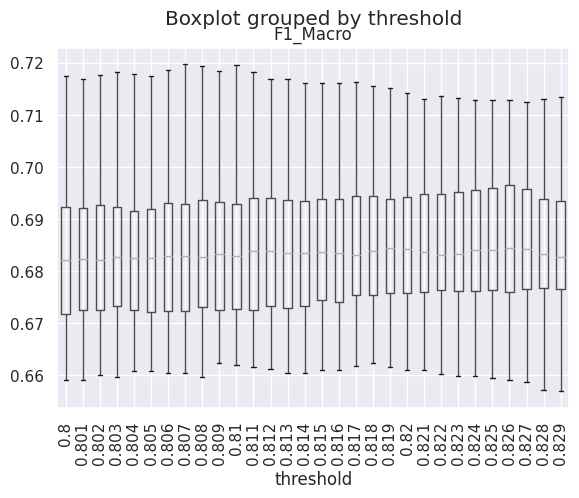

In [ ]:
score.boxplot('F1_Macro',by='threshold',rot=90)

In [ ]:
def simulate_by_test(threshold=0.825,count=1000):
    values=[]
    for outer_iter in range(48):
        df_raw_outer = df_raw[df_raw['iter']==outer_iter]
        y = pd.DataFrame({'y_true':list(df_raw_outer['y_true']),'y_pred':list(df_raw_outer['y_pred'])})
        y_true, y_pred = y['y_true'], y['y_pred']
        f1_val = f1_score(y_true, y_pred >= threshold, average='macro')
        for i in range(count):
            new_seed = SEED + i*1000
            y1, y2 = train_test_split(y, test_size=0.5, stratify=y['y_true'], random_state=new_seed)
            f1_val_1 = f1_score(y1['y_true'], (y1['y_pred'] >= threshold).astype(int), average='macro')
            f1_val_2 = f1_score(y2['y_true'], (y2['y_pred'] >= threshold).astype(int), average='macro')
            values.append([outer_iter,i,f1_val,min(f1_val_1, f1_val_2),max(f1_val_1, f1_val_2),max(f1_val_1, f1_val_2) - min(f1_val_1, f1_val_2)])
    return pd.DataFrame(values, columns=['outer_iter','count','f1_val','f1_min','f1_max','f1_diff'])

df_sim = simulate_by_test()
df_sim.describe()

,outer_iter,count,f1_val,f1_min,f1_max,f1_diff
count,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000
mean,23.500000,499.500000,0.684866,0.674930,0.694647,0.019717
std,13.853543,288.677997,0.013266,0.015355,0.015127,0.014991
min,0.000000,0.000000,0.659470,0.609763,0.659414,0.000000
25%,11.750000,249.750000,0.676391,0.664423,0.684192,0.007757
50%,23.500000,499.500000,0.684059,0.674801,0.693253,0.016563
75%,35.250000,749.250000,0.696047,0.685154,0.705479,0.028592
max,47.000000,999.000000,0.712843,0.712807,0.757042,0.101174


In [ ]:
def stat(threshold, score):
  df_sim = simulate_by_test(threshold=threshold)
  sim1 = df_sim[(df_sim['f1_max']>score)&(df_sim['f1_min']<score)].copy()
  sim2 = df_sim[df_sim['f1_min']>score].copy()
  sim1['group'] = '1'
  sim2['group'] = '2'
  sim = pd.concat([sim1,sim2], ignore_index=True).reset_index(drop=True)
  return sim
sim = stat(0.825, 0.6896)
sim.describe()

,outer_iter,count,f1_val,f1_min,f1_max,f1_diff
count,28686.000000,28686.000000,28686.000000,28686.000000,28686.000000,28686.000000
mean,23.959353,498.865300,0.692297,0.679953,0.704444,0.024491
std,13.746050,288.558977,0.010701,0.015652,0.010452,0.015725
min,0.000000,0.000000,0.659470,0.609763,0.689627,0.000000
25%,12.000000,249.000000,0.684290,0.669024,0.695729,0.012264
50%,24.000000,498.000000,0.691066,0.680295,0.702943,0.022398
75%,36.000000,748.000000,0.699884,0.692421,0.711181,0.034163
max,47.000000,999.000000,0.712843,0.712807,0.757042,0.101174


In [ ]:
sim['group'].value_counts()/len(sim)

1    0.680785
2    0.319215
Name: group, dtype: float64

In [ ]:
pd.Series(list(sim['f1_min'])+list(sim['f1_max'])).quantile(np.arange(0,1,0.05))

0.00    0.609763
0.05    0.659275
0.10    0.666230
0.15    0.671708
0.20    0.676027
0.25    0.680295
0.30    0.685845
0.35    0.689920
0.40    0.691472
0.45    0.693068
0.50    0.694658
0.55    0.696282
0.60    0.698012
0.65    0.699885
0.70    0.701969
0.75    0.704169
0.80    0.706683
0.85    0.709651
0.90    0.713398
0.95    0.719119
dtype: float64

In [ ]:
def stat2(threshold, score, min_score=0.68):
  df_sim = simulate_by_test(threshold=threshold)
  df_sim = df_sim[df_sim['f1_val']>min_score]
  sim1 = df_sim[(df_sim['f1_max']>score)&(df_sim['f1_min']<score)].copy()
  sim2 = df_sim[df_sim['f1_min']>score].copy()
  sim1['group'] = '1'
  sim2['group'] = '2'
  sim = pd.concat([sim1,sim2], ignore_index=True).reset_index(drop=True)
  return sim
sim2 = stat2(0.82, 0.6887)
sim2.describe()

,outer_iter,count,f1_val,f1_min,f1_max,f1_diff
count,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000
mean,24.521558,498.925547,0.694704,0.683855,0.705379,0.021523
std,13.450898,288.662210,0.009174,0.012646,0.010882,0.014800
min,1.000000,0.000000,0.681520,0.635521,0.688766,0.000000
25%,14.000000,249.000000,0.685900,0.674781,0.696379,0.010177
50%,24.000000,499.000000,0.693957,0.683390,0.704001,0.018791
75%,36.000000,748.250000,0.701761,0.693204,0.712551,0.030113
max,46.000000,999.000000,0.714249,0.714249,0.757502,0.098494


In [ ]:
models

[[0,
  'stk',
  StackingClassifier(estimators=[('cbt_s',
                                  Pipeline(steps=[('fillnatransformer',
                                                   FillNATransformer(columns=['Term',
                                                                              'NoEmp',
                                                                              'NewExist',
                                                                              'CreateJob',
                                                                              'RetainedJob',
                                                                              'FranchiseCode',
                                                                              'RevLineCr',
                                                                              'LowDoc',
                                                                              'Sector',
                                                              

In [ ]:
if os.path.exists(os.path.join(MODEL_DIR,'model_v2_11.pkl')) == False:
    with open(os.path.join(MODEL_DIR,'model_v2_11.pkl'),'wb') as f:
        dill.dump((df_score,models),f)

<Axes: title={'center': 'auc'}, xlabel='name'>

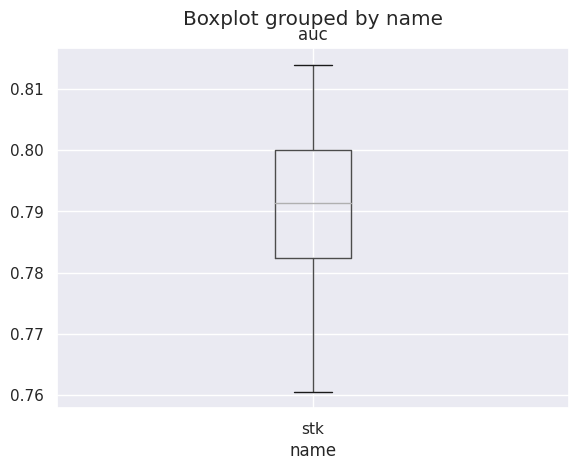

In [ ]:
df_score.boxplot('auc',by='name')

In [ ]:
df_score.describe()

,iter,auc,f1_0.5,f1_0.55,f1_0.6,f1_0.65,f1_0.7,f1_0.75,f1_0.8,f1_0.81,f1_0.82,f1_0.825,f1_0.83,f1_0.84,f1_0.85,recall_0.5,recall_0.55,recall_0.6,recall_0.65,recall_0.7,recall_0.75,recall_0.8,recall_0.81,recall_0.82,recall_0.825,recall_0.83,recall_0.84,recall_0.85,precision_0.5,precision_0.55,precision_0.6,precision_0.65,precision_0.7,precision_0.75,precision_0.8,precision_0.81,precision_0.82,precision_0.825,precision_0.83,precision_0.84,precision_0.85
count,48.00,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,23.50,0.790918,0.649458,0.657409,0.665060,0.671426,0.676922,0.681118,0.684107,0.684196,0.684861,0.684866,0.684385,0.683513,0.681264,0.984649,0.982551,0.980214,0.977216,0.973370,0.967591,0.956788,0.953524,0.949784,0.947745,0.945131,0.938756,0.931117,0.915080,0.916682,0.918358,0.920006,0.921734,0.923686,0.926565,0.927299,0.928287,0.928752,0.929234,0.930499,0.931745
std,14.00,0.012942,0.014686,0.013688,0.013591,0.014067,0.013242,0.013825,0.014788,0.014264,0.013650,0.013407,0.013242,0.012445,0.011965,0.002051,0.002165,0.002330,0.002393,0.002691,0.002784,0.003558,0.003650,0.003465,0.003517,0.003479,0.003629,0.004117,0.002381,0.002265,0.002325,0.002498,0.002542,0.002817,0.003165,0.003165,0.003122,0.003131,0.003124,0.003034,0.003118
min,0.00,0.760497,0.615670,0.626658,0.635774,0.646194,0.654123,0.659980,0.659182,0.661961,0.660942,0.659470,0.659435,0.658321,0.653104,0.979981,0.978074,0.975214,0.972990,0.969177,0.963457,0.949476,0.945663,0.941214,0.939307,0.937401,0.931045,0.919924,0.910136,0.911939,0.913819,0.916019,0.917767,0.919326,0.921533,0.922018,0.923314,0.923340,0.924011,0.925181,0.925573
25%,11.75,0.782381,0.638009,0.648289,0.654943,0.661474,0.665243,0.671458,0.671802,0.672762,0.675839,0.676391,0.676062,0.674518,0.672739,0.983163,0.980934,0.978074,0.975214,0.971640,0.964737,0.953939,0.950758,0.947569,0.945901,0.943041,0.937003,0.928424,0.913201,0.915015,0.916549,0.918051,0.919762,0.921681,0.924002,0.925296,0.926170,0.926822,0.927580,0.928872,0.929245
50%,23.50,0.791345,0.650607,0.655926,0.665693,0.672800,0.675093,0.679083,0.682183,0.682989,0.684321,0.684059,0.682489,0.683298,0.681237,0.984588,0.982682,0.980302,0.977598,0.972994,0.967747,0.956625,0.952812,0.949476,0.947419,0.945027,0.938990,0.931533,0.915107,0.916444,0.918189,0.920042,0.921326,0.922983,0.926325,0.926987,0.927973,0.928248,0.928571,0.929990,0.931478
75%,35.25,0.800090,0.657003,0.670909,0.674910,0.682600,0.688078,0.689517,0.692270,0.692916,0.694238,0.696047,0.692780,0.692126,0.690005,0.986101,0.984430,0.981889,0.979029,0.975534,0.969892,0.958532,0.955517,0.952022,0.949877,0.947343,0.940677,0.933445,0.916654,0.918587,0.919830,0.921946,0.923338,0.925080,0.928252,0.929191,0.930640,0.931482,0.931702,0.932613,0.933747
max,47.00,0.813980,0.682036,0.682203,0.692838,0.696985,0.708000,0.712101,0.717394,0.719594,0.714249,0.712843,0.713418,0.707683,0.708558,0.988564,0.986658,0.984752,0.982529,0.979670,0.972999,0.965046,0.960915,0.957420,0.955831,0.953939,0.946315,0.938990,0.920559,0.920943,0.923192,0.924699,0.928138,0.931003,0.934539,0.935757,0.936043,0.936433,0.936825,0.938220,0.939325


In [ ]:
df_score[df_score['name']=='stk'][F1_COLUMNS].describe()

,f1_0.5,f1_0.55,f1_0.6,f1_0.65,f1_0.7,f1_0.75,f1_0.8,f1_0.81,f1_0.82,f1_0.825,f1_0.83,f1_0.84,f1_0.85
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,0.649458,0.657409,0.665060,0.671426,0.676922,0.681118,0.684107,0.684196,0.684861,0.684866,0.684385,0.683513,0.681264
std,0.014686,0.013688,0.013591,0.014067,0.013242,0.013825,0.014788,0.014264,0.013650,0.013407,0.013242,0.012445,0.011965
min,0.615670,0.626658,0.635774,0.646194,0.654123,0.659980,0.659182,0.661961,0.660942,0.659470,0.659435,0.658321,0.653104
25%,0.638009,0.648289,0.654943,0.661474,0.665243,0.671458,0.671802,0.672762,0.675839,0.676391,0.676062,0.674518,0.672739
50%,0.650607,0.655926,0.665693,0.672800,0.675093,0.679083,0.682183,0.682989,0.684321,0.684059,0.682489,0.683298,0.681237
75%,0.657003,0.670909,0.674910,0.682600,0.688078,0.689517,0.692270,0.692916,0.694238,0.696047,0.692780,0.692126,0.690005
max,0.682036,0.682203,0.692838,0.696985,0.708000,0.712101,0.717394,0.719594,0.714249,0.712843,0.713418,0.707683,0.708558


In [ ]:
df_score[df_score['name']=='stk'][RECALL_COLUMNS].describe()

,recall_0.5,recall_0.55,recall_0.6,recall_0.65,recall_0.7,recall_0.75,recall_0.8,recall_0.81,recall_0.82,recall_0.825,recall_0.83,recall_0.84,recall_0.85
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,0.984649,0.982551,0.980214,0.977216,0.973370,0.967591,0.956788,0.953524,0.949784,0.947745,0.945131,0.938756,0.931117
std,0.002051,0.002165,0.002330,0.002393,0.002691,0.002784,0.003558,0.003650,0.003465,0.003517,0.003479,0.003629,0.004117
min,0.979981,0.978074,0.975214,0.972990,0.969177,0.963457,0.949476,0.945663,0.941214,0.939307,0.937401,0.931045,0.919924
25%,0.983163,0.980934,0.978074,0.975214,0.971640,0.964737,0.953939,0.950758,0.947569,0.945901,0.943041,0.937003,0.928424
50%,0.984588,0.982682,0.980302,0.977598,0.972994,0.967747,0.956625,0.952812,0.949476,0.947419,0.945027,0.938990,0.931533
75%,0.986101,0.984430,0.981889,0.979029,0.975534,0.969892,0.958532,0.955517,0.952022,0.949877,0.947343,0.940677,0.933445
max,0.988564,0.986658,0.984752,0.982529,0.979670,0.972999,0.965046,0.960915,0.957420,0.955831,0.953939,0.946315,0.938990


In [ ]:
df_score[df_score['name']=='stk'][PRECISION_COLUMNS].describe()

,precision_0.5,precision_0.55,precision_0.6,precision_0.65,precision_0.7,precision_0.75,precision_0.8,precision_0.81,precision_0.82,precision_0.825,precision_0.83,precision_0.84,precision_0.85
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,0.915080,0.916682,0.918358,0.920006,0.921734,0.923686,0.926565,0.927299,0.928287,0.928752,0.929234,0.930499,0.931745
std,0.002381,0.002265,0.002325,0.002498,0.002542,0.002817,0.003165,0.003165,0.003122,0.003131,0.003124,0.003034,0.003118
min,0.910136,0.911939,0.913819,0.916019,0.917767,0.919326,0.921533,0.922018,0.923314,0.923340,0.924011,0.925181,0.925573
25%,0.913201,0.915015,0.916549,0.918051,0.919762,0.921681,0.924002,0.925296,0.926170,0.926822,0.927580,0.928872,0.929245
50%,0.915107,0.916444,0.918189,0.920042,0.921326,0.922983,0.926325,0.926987,0.927973,0.928248,0.928571,0.929990,0.931478
75%,0.916654,0.918587,0.919830,0.921946,0.923338,0.925080,0.928252,0.929191,0.930640,0.931482,0.931702,0.932613,0.933747
max,0.920559,0.920943,0.923192,0.924699,0.928138,0.931003,0.934539,0.935757,0.936043,0.936433,0.936825,0.938220,0.939325


In [ ]:
pred = pd.DataFrame()
for [iter, name, model] in models:
  if name == 'stk':
    pred[iter] = model.predict_proba(test_prepared)[:,1]
pred_final = (pred[pred.columns].apply(np.mean,axis=1) > 0.83).astype(int)
pred_final.value_counts()/len(pred_final)

1    0.908788
0    0.091212
dtype: float64

In [ ]:
def save_submit(pred,pred_column:str):
  """
  submissionファイル作成

  Parameters
  ----------
  pred_column : str
      予測ラベルカラム名
  """
  sample_submission[pred_column] = pred.values
  sub_file = 'submit_{0}_{1:%Y%m%d_%H%M}.csv'.format(pred_column, datetime.datetime.now())
  sub_file = os.path.join(DATA_DIR, sub_file)
  sample_submission[[pred_column]].to_csv(sub_file, header=None)
  print('submit file : ',sub_file)

#save_submit(pred_final, 'voting_01_v2_05_CPU')

In [ ]:
save_submit(pred_final, f'stacking_01_{VER}_083_CPU')

submit file :  /Volumes/ws_fduacmp_001/adbuser0375/datasets/submit_stacking_01_v2_11_1_083_CPU_20240215_0133.csv


In [ ]:
pred = pd.DataFrame()
for [iter, name, model] in models:
  if name == 'stk':
    pred[iter] = model.predict_proba(test_prepared)[:,1]
pred_final = (pred[pred.columns].apply(np.mean,axis=1) > 0.81).astype(int)
pred_final.value_counts()/len(pred_final)

1    0.918313
0    0.081687
dtype: float64

In [ ]:
save_submit(pred_final, f'stacking_01_{VER}_081_CPU')

submit file :  /Volumes/ws_fduacmp_001/adbuser0375/datasets/submit_stacking_01_v2_11_1_081_CPU_20240215_0139.csv


In [ ]:
pred = pd.DataFrame()
for [iter, name, model] in models:
  if name == 'stk':
    pred[iter] = model.predict_proba(test_prepared)[:,1]
pred_final = (pred[pred.columns].apply(np.mean,axis=1) > 0.82).astype(int)
pred_final.value_counts()/len(pred_final)

1    0.913681
0    0.086319
dtype: float64

In [ ]:
save_submit(pred_final, f'stacking_01_{VER}_082_CPU')

submit file :  /Volumes/ws_fduacmp_001/adbuser0375/datasets/submit_stacking_01_v2_11_1_082_CPU_20240215_0146.csv


In [ ]:
pred = pd.DataFrame()
for [iter, name, model] in models:
    pred[iter] = model.predict_proba(test_prepared)[:,1]
pred_final = (pred[pred.columns].apply(np.mean,axis=1) > 0.825).astype(int)
pred_final.value_counts()/len(pred_final)

1    0.911293
0    0.088707
dtype: float64

In [ ]:
save_submit(pred_final, f'stacking_01_{VER}_0825_CPU')

submit file :  /Volumes/ws_fduacmp_001/adbuser0375/datasets/submit_stacking_01_v2_11_1_0825_CPU_20240215_0704.csv


In [ ]:
df_score[df_score['f1_0.82']>0.676][F1_COLUMNS].describe()

,f1_0.5,f1_0.55,f1_0.6,f1_0.65,f1_0.7,f1_0.75,f1_0.8,f1_0.81,f1_0.82,f1_0.825,f1_0.83,f1_0.84,f1_0.85
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.654270,0.662289,0.669634,0.676319,0.681312,0.685670,0.689681,0.689712,0.690486,0.690334,0.689855,0.688658,0.685950
std,0.013307,0.011931,0.012363,0.012250,0.012245,0.012834,0.012605,0.011879,0.010624,0.010381,0.010154,0.009329,0.009376
min,0.615670,0.626658,0.635774,0.646194,0.654123,0.660765,0.667837,0.672181,0.676185,0.676255,0.674271,0.673994,0.671329
25%,0.647124,0.655366,0.662514,0.668726,0.674219,0.676798,0.680378,0.681163,0.683730,0.682464,0.681602,0.682102,0.678791
50%,0.655045,0.661233,0.669664,0.676012,0.680059,0.682982,0.685685,0.684973,0.687404,0.686087,0.687366,0.686729,0.682935
75%,0.663369,0.671882,0.679193,0.684998,0.690740,0.696271,0.696939,0.696605,0.699876,0.698619,0.697080,0.696943,0.692739
max,0.682036,0.682203,0.692838,0.696985,0.708000,0.712101,0.717394,0.719594,0.714249,0.712843,0.713418,0.707683,0.708558


In [ ]:
pred = pd.DataFrame()
for i, (score,[iter, name, model]) in enumerate(zip(df_score['f1_0.82'],models)):
  if score > 0.676:
    pred[i] = model.predict_proba(test_prepared)[:,1]
pred_final = (pred[pred.columns].apply(np.mean,axis=1) > 0.82).astype(int)
pred_final.value_counts()/len(pred_final)

1    0.914012
0    0.085988
dtype: float64

In [ ]:
pred

,0,1,2,3,6,8,9,10,11,12,14,16,17,19,20,22,23,24,25,27,28,29,30,31,32,34,35,36,37,38,40,43,44,45,46,47
0,0.307716,0.358684,0.240030,0.377254,0.209034,0.314829,0.296132,0.268376,0.266272,0.222656,0.301111,0.349605,0.183972,0.304758,0.323199,0.316655,0.325560,0.278980,0.339720,0.326142,0.307141,0.279758,0.339663,0.312635,0.333005,0.264397,0.245285,0.461167,0.306113,0.372639,0.227728,0.353207,0.322027,0.262981,0.193349,0.408370
1,0.951338,0.949264,0.950493,0.950462,0.950341,0.950410,0.950542,0.951579,0.951769,0.949950,0.950159,0.948243,0.951145,0.949965,0.951912,0.949761,0.948898,0.950924,0.950578,0.948905,0.950217,0.950142,0.950749,0.951354,0.951477,0.952000,0.952062,0.950795,0.948422,0.949733,0.950618,0.952190,0.952641,0.947808,0.950725,0.950895
2,0.412726,0.326380,0.454999,0.505887,0.556604,0.353370,0.289993,0.354835,0.246302,0.266917,0.430786,0.264601,0.289790,0.313607,0.505373,0.258112,0.420916,0.425815,0.637321,0.483957,0.356185,0.430741,0.306090,0.332051,0.280511,0.422668,0.401537,0.592458,0.474887,0.383297,0.464518,0.368172,0.507487,0.504660,0.240350,0.402719
3,0.872258,0.867769,0.863273,0.871854,0.866947,0.859860,0.846056,0.876023,0.844742,0.862858,0.851332,0.867431,0.879175,0.843623,0.863151,0.849429,0.882421,0.849140,0.863401,0.815947,0.864222,0.862053,0.872656,0.852277,0.820177,0.850967,0.862295,0.848825,0.875826,0.887419,0.871112,0.857551,0.860818,0.811971,0.859769,0.830838
4,0.951286,0.947813,0.948773,0.952406,0.949545,0.951172,0.950400,0.951291,0.949092,0.949324,0.949793,0.949493,0.951152,0.952756,0.950880,0.950654,0.948190,0.949729,0.951115,0.948946,0.945940,0.948680,0.949321,0.948655,0.951564,0.948697,0.950453,0.951278,0.950350,0.950921,0.951003,0.950132,0.947823,0.949953,0.947619,0.952169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42303,0.948410,0.944392,0.944983,0.946877,0.947243,0.943605,0.944353,0.948964,0.939998,0.949264,0.945569,0.943908,0.948345,0.947702,0.947724,0.946049,0.946561,0.939716,0.946232,0.946536,0.943393,0.948243,0.946836,0.947934,0.948981,0.941233,0.947140,0.943918,0.948573,0.947530,0.947836,0.946009,0.945857,0.949807,0.945048,0.945429
42304,0.934920,0.936566,0.936583,0.941052,0.937819,0.939671,0.936156,0.933254,0.935699,0.935312,0.935737,0.938051,0.936663,0.938090,0.937593,0.938001,0.934081,0.935531,0.938744,0.937623,0.934904,0.939498,0.937739,0.937844,0.933518,0.938774,0.935732,0.938877,0.935522,0.935346,0.934742,0.935850,0.937963,0.936789,0.931637,0.938057
42305,0.937323,0.938386,0.936665,0.935234,0.937039,0.936527,0.939504,0.935261,0.935480,0.934839,0.937824,0.937412,0.937330,0.939498,0.933088,0.936640,0.936370,0.940914,0.932316,0.937547,0.936274,0.936237,0.938817,0.936059,0.940601,0.935705,0.934278,0.934723,0.937950,0.937686,0.934316,0.932493,0.935148,0.937735,0.934324,0.936564
42306,0.944314,0.940267,0.941669,0.942965,0.944864,0.942396,0.943909,0.944994,0.943874,0.940467,0.938936,0.944649,0.942909,0.943162,0.945561,0.941616,0.942081,0.942036,0.944183,0.943806,0.943127,0.944306,0.944605,0.944297,0.945147,0.942025,0.942353,0.943819,0.944224,0.945115,0.942879,0.943547,0.945908,0.941538,0.941847,0.941511


In [ ]:
save_submit(pred_final, f'stacking_01_{VER}_sel_CPU_082')

submit file :  /Volumes/ws_fduacmp_001/adbuser0375/datasets/submit_stacking_01_v2_11_1_sel_CPU_082_20240215_0151.csv


In [ ]:
pred = pd.DataFrame()
for i, (score,[iter, name, model]) in enumerate(zip(df_score['f1_0.82'],models)):
  if score > 0.676:
    pred[i] = model.predict_proba(test_prepared)[:,1]
pred_final = (pred[pred.columns].apply(np.mean,axis=1) > 0.825).astype(int)
pred_final.value_counts()/len(pred_final)

1    0.911175
0    0.088825
dtype: float64

In [ ]:
save_submit(pred_final, f'stacking_01_{VER}_sel_CPU_0825')

submit file :  /Volumes/ws_fduacmp_001/adbuser0375/datasets/submit_stacking_01_v2_11_1_sel_CPU_0825_20240215_0156.csv


In [ ]:
pred

,0,1,2,3,6,8,9,10,11,12,14,16,17,19,20,22,23,24,25,27,28,29,30,31,32,34,35,36,37,38,40,43,44,45,46,47
0,0.307716,0.358684,0.240030,0.377254,0.209034,0.314829,0.296132,0.268376,0.266272,0.222656,0.301111,0.349605,0.183972,0.304758,0.323199,0.316655,0.325560,0.278980,0.339720,0.326142,0.307141,0.279758,0.339663,0.312635,0.333005,0.264397,0.245285,0.461167,0.306113,0.372639,0.227728,0.353207,0.322027,0.262981,0.193349,0.408370
1,0.951338,0.949264,0.950493,0.950462,0.950341,0.950410,0.950542,0.951579,0.951769,0.949950,0.950159,0.948243,0.951145,0.949965,0.951912,0.949761,0.948898,0.950924,0.950578,0.948905,0.950217,0.950142,0.950749,0.951354,0.951477,0.952000,0.952062,0.950795,0.948422,0.949733,0.950618,0.952190,0.952641,0.947808,0.950725,0.950895
2,0.412726,0.326380,0.454999,0.505887,0.556604,0.353370,0.289993,0.354835,0.246302,0.266917,0.430786,0.264601,0.289790,0.313607,0.505373,0.258112,0.420916,0.425815,0.637321,0.483957,0.356185,0.430741,0.306090,0.332051,0.280511,0.422668,0.401537,0.592458,0.474887,0.383297,0.464518,0.368172,0.507487,0.504660,0.240350,0.402719
3,0.872258,0.867769,0.863273,0.871854,0.866947,0.859860,0.846056,0.876023,0.844742,0.862858,0.851332,0.867431,0.879175,0.843623,0.863151,0.849429,0.882421,0.849140,0.863401,0.815947,0.864222,0.862053,0.872656,0.852277,0.820177,0.850967,0.862295,0.848825,0.875826,0.887419,0.871112,0.857551,0.860818,0.811971,0.859769,0.830838
4,0.951286,0.947813,0.948773,0.952406,0.949545,0.951172,0.950400,0.951291,0.949092,0.949324,0.949793,0.949493,0.951152,0.952756,0.950880,0.950654,0.948190,0.949729,0.951115,0.948946,0.945940,0.948680,0.949321,0.948655,0.951564,0.948697,0.950453,0.951278,0.950350,0.950921,0.951003,0.950132,0.947823,0.949953,0.947619,0.952169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42303,0.948410,0.944392,0.944983,0.946877,0.947243,0.943605,0.944353,0.948964,0.939998,0.949264,0.945569,0.943908,0.948345,0.947702,0.947724,0.946049,0.946561,0.939716,0.946232,0.946536,0.943393,0.948243,0.946836,0.947934,0.948981,0.941233,0.947140,0.943918,0.948573,0.947530,0.947836,0.946009,0.945857,0.949807,0.945048,0.945429
42304,0.934920,0.936566,0.936583,0.941052,0.937819,0.939671,0.936156,0.933254,0.935699,0.935312,0.935737,0.938051,0.936663,0.938090,0.937593,0.938001,0.934081,0.935531,0.938744,0.937623,0.934904,0.939498,0.937739,0.937844,0.933518,0.938774,0.935732,0.938877,0.935522,0.935346,0.934742,0.935850,0.937963,0.936789,0.931637,0.938057
42305,0.937323,0.938386,0.936665,0.935234,0.937039,0.936527,0.939504,0.935261,0.935480,0.934839,0.937824,0.937412,0.937330,0.939498,0.933088,0.936640,0.936370,0.940914,0.932316,0.937547,0.936274,0.936237,0.938817,0.936059,0.940601,0.935705,0.934278,0.934723,0.937950,0.937686,0.934316,0.932493,0.935148,0.937735,0.934324,0.936564
42306,0.944314,0.940267,0.941669,0.942965,0.944864,0.942396,0.943909,0.944994,0.943874,0.940467,0.938936,0.944649,0.942909,0.943162,0.945561,0.941616,0.942081,0.942036,0.944183,0.943806,0.943127,0.944306,0.944605,0.944297,0.945147,0.942025,0.942353,0.943819,0.944224,0.945115,0.942879,0.943547,0.945908,0.941538,0.941847,0.941511


In [ ]:
pred = pd.DataFrame()
for i, (score,[iter, name, model]) in enumerate(zip(df_score['f1_0.82'],models)):
  if score > 0.676:
    pred[i] = model.predict_proba(test_prepared)[:,1]
pred_final = (pred[pred.columns].apply(np.mean,axis=1) > 0.83).astype(int)
pred_final.value_counts()/len(pred_final)

1    0.90893
0    0.09107
dtype: float64

In [ ]:
save_submit(pred_final, f'stacking_01_{VER}_sel_CPU_083')

submit file :  /Volumes/ws_fduacmp_001/adbuser0375/datasets/submit_stacking_01_v2_11_1_sel_CPU_083_20240215_0201.csv


In [ ]:
df_score[df_score['f1_0.82']>0.68][F1_COLUMNS].describe()

,f1_0.5,f1_0.55,f1_0.6,f1_0.65,f1_0.7,f1_0.75,f1_0.8,f1_0.81,f1_0.82,f1_0.825,f1_0.83,f1_0.84,f1_0.85
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,0.657247,0.665119,0.672151,0.678820,0.683679,0.687701,0.692813,0.692816,0.693599,0.693257,0.692386,0.690933,0.688123
std,0.011429,0.010171,0.010920,0.010784,0.011415,0.012747,0.011813,0.011086,0.009442,0.009418,0.009603,0.008880,0.009060
min,0.630883,0.647050,0.654153,0.655734,0.662076,0.668168,0.679381,0.680505,0.681520,0.681654,0.678321,0.674693,0.671329
25%,0.650409,0.655785,0.665420,0.674561,0.674478,0.676867,0.683339,0.683818,0.685030,0.684798,0.683949,0.683696,0.682159
50%,0.655643,0.662359,0.671764,0.679927,0.683270,0.683107,0.689895,0.689410,0.692327,0.691066,0.691414,0.689054,0.688169
75%,0.663962,0.673120,0.680390,0.685753,0.691651,0.697593,0.701636,0.698772,0.700773,0.699884,0.699364,0.698906,0.695984
max,0.682036,0.682203,0.692838,0.696985,0.708000,0.712101,0.717394,0.719594,0.714249,0.712843,0.713418,0.707683,0.708558


In [ ]:
pred = pd.DataFrame()
for i, (score,[iter, name, model]) in enumerate(zip(df_score['f1_0.82'],models)):
  if score > 0.68:
    pred[i] = model.predict_proba(test_prepared)[:,1]
pred_final = (pred[pred.columns].apply(np.mean,axis=1) > 0.83).astype(int)
pred_final.value_counts()/len(pred_final)

1    0.908599
0    0.091401
dtype: float64

In [ ]:
save_submit(pred_final, f'stacking_01_v2_{VER}_CPU_083_2')

submit file :  /Volumes/ws_fduacmp_001/adbuser0375/datasets/submit_stacking_01_v2_v2_11_1_CPU_083_2_20240215_0205.csv


In [ ]:
df_score[df_score['f1_0.82']>0.676][RECALL_COLUMNS].describe()

,recall_0.5,recall_0.55,recall_0.6,recall_0.65,recall_0.7,recall_0.75,recall_0.8,recall_0.81,recall_0.82,recall_0.825,recall_0.83,recall_0.84,recall_0.85
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.984652,0.982719,0.980371,0.977405,0.973584,0.967653,0.957176,0.954025,0.950327,0.948262,0.945641,0.939242,0.931219
std,0.002139,0.002158,0.002391,0.002479,0.002771,0.002929,0.003525,0.003532,0.003367,0.003372,0.003411,0.003643,0.004386
min,0.979981,0.978074,0.976486,0.972990,0.969177,0.963457,0.952653,0.948522,0.944074,0.940896,0.937718,0.931363,0.919924
25%,0.983159,0.980939,0.978074,0.975453,0.971640,0.964728,0.953939,0.951303,0.947887,0.946219,0.943438,0.937321,0.928344
50%,0.984588,0.982682,0.980775,0.977915,0.973308,0.967911,0.956625,0.953289,0.949643,0.948046,0.945839,0.939327,0.931533
75%,0.986336,0.984747,0.982207,0.979112,0.975540,0.970212,0.959326,0.956232,0.952033,0.950127,0.947569,0.941214,0.934318
max,0.988564,0.986658,0.984752,0.982529,0.979670,0.972999,0.965046,0.960915,0.957420,0.955831,0.953939,0.946315,0.938990


In [ ]:
df_score[df_score['f1_0.82']>0.676][PRECISION_COLUMNS].describe()

,precision_0.5,precision_0.55,precision_0.6,precision_0.65,precision_0.7,precision_0.75,precision_0.8,precision_0.81,precision_0.82,precision_0.825,precision_0.83,precision_0.84,precision_0.85
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.915874,0.917495,0.919151,0.920882,0.922554,0.924613,0.927739,0.928467,0.929507,0.929960,0.930465,0.931709,0.932981
std,0.002147,0.001979,0.002102,0.002178,0.002378,0.002601,0.002739,0.002729,0.002570,0.002576,0.002529,0.002396,0.002458
min,0.910136,0.911939,0.913819,0.916019,0.917767,0.920048,0.923455,0.925170,0.925732,0.926293,0.926594,0.928100,0.929226
25%,0.914648,0.916155,0.917624,0.919410,0.921094,0.922468,0.925668,0.926630,0.927590,0.927830,0.928377,0.929689,0.931059
50%,0.915978,0.917371,0.919242,0.920875,0.922014,0.924010,0.927220,0.927896,0.928672,0.929542,0.930054,0.931475,0.932730
75%,0.917091,0.918913,0.921006,0.922231,0.924129,0.926577,0.929138,0.929940,0.931106,0.931859,0.932130,0.933527,0.934787
max,0.920559,0.920943,0.923192,0.924699,0.928138,0.931003,0.934539,0.935757,0.936043,0.936433,0.936825,0.938220,0.939325


In [ ]:
pred = pd.DataFrame()
for i, (score,[iter, name, model]) in enumerate(zip(df_score['f1_0.82'],models)):
  if score > 0.68:
    pred[i] = model.predict_proba(test_prepared)[:,1]
pred_final = (pred[pred.columns].apply(np.mean,axis=1) > 0.82).astype(int)
pred_final.value_counts()/len(pred_final)

1    0.91387
0    0.08613
dtype: float64

In [ ]:
save_submit(pred_final, f'stacking_01_v2_{VER}_sel_CPU_082_over_068')

submit file :  /Volumes/ws_fduacmp_001/adbuser0375/datasets/submit_stacking_01_v2_v2_11_1_sel_CPU_082_over_068_20240215_0209.csv


In [ ]:
pred = pd.DataFrame()
for i, (score,[iter, name, model]) in enumerate(zip(df_score['f1_0.82'],models)):
  if score <= 0.68:
    pred[i] = model.predict_proba(test_prepared)[:,1]
pred_final = (pred[pred.columns].apply(np.mean,axis=1) > 0.82).astype(int)
pred_final.value_counts()/len(pred_final)

1    0.913822
0    0.086178
dtype: float64

In [ ]:
save_submit(pred_final, f'stacking_01_v2_{VER}_sel_CPU_082_under_068')

submit file :  /Volumes/ws_fduacmp_001/adbuser0375/datasets/submit_stacking_01_v2_v2_11_1_sel_CPU_082_under_068_20240215_0211.csv
